# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

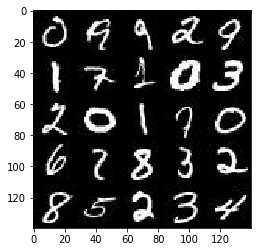

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

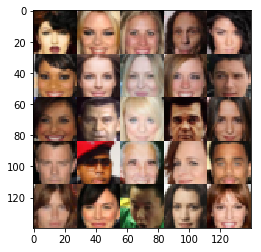

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),name = 'input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim),name = 'input_z')
    learning_rate = tf.placeholder(tf.float32, None)

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False,alpha=0.2):
    
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.nn.dropout(relu3, 0.8)
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, training= True,alpha = 0.2):
    """ 
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse= not training):
          
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.5)
        
        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, 0.5)
        
        x3 = tf.layers.conv2d_transpose(x2, 32, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, 0.5)
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [24]:
def model_loss(input_real, input_z, out_channel_dim, alpha =0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function

    g_model = generator(input_z, out_channel_dim,alpha =alpha)

    d_model_real, d_logits_real = discriminator(input_real,alpha =alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True,alpha =alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake


    return d_loss, g_loss








"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [25]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [32]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    samples, losses = [], []
    steps = 0
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha =0.2)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images*2
                batch_z = np.random.uniform(-1, 1, size=(batch_size,z_dim))
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, input_real:batch_images, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, input_real:batch_images, learn_rate: learning_rate})
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
    print('project finished')
    return losses, samples

          

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3334... Generator Loss: 0.6282
Epoch 1/2... Discriminator Loss: 1.5636... Generator Loss: 0.5663
Epoch 1/2... Discriminator Loss: 1.5061... Generator Loss: 0.6262
Epoch 1/2... Discriminator Loss: 1.4740... Generator Loss: 0.5329
Epoch 1/2... Discriminator Loss: 1.3704... Generator Loss: 0.6961
Epoch 1/2... Discriminator Loss: 1.3934... Generator Loss: 0.6011
Epoch 1/2... Discriminator Loss: 1.4001... Generator Loss: 0.6869
Epoch 1/2... Discriminator Loss: 1.3415... Generator Loss: 0.7429
Epoch 1/2... Discriminator Loss: 1.3437... Generator Loss: 0.6462
Epoch 1/2... Discriminator Loss: 1.3108... Generator Loss: 0.7573


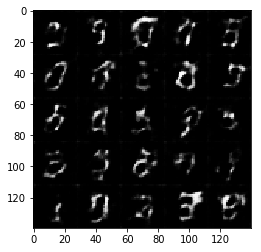

Epoch 1/2... Discriminator Loss: 1.3168... Generator Loss: 0.7274
Epoch 1/2... Discriminator Loss: 1.3818... Generator Loss: 0.6079
Epoch 1/2... Discriminator Loss: 1.3616... Generator Loss: 0.6586
Epoch 1/2... Discriminator Loss: 1.2831... Generator Loss: 0.6783
Epoch 1/2... Discriminator Loss: 1.3207... Generator Loss: 0.7169
Epoch 1/2... Discriminator Loss: 1.3485... Generator Loss: 0.7239
Epoch 1/2... Discriminator Loss: 1.3027... Generator Loss: 0.7537
Epoch 1/2... Discriminator Loss: 1.3155... Generator Loss: 0.6652
Epoch 1/2... Discriminator Loss: 1.3689... Generator Loss: 0.5673
Epoch 1/2... Discriminator Loss: 1.3184... Generator Loss: 0.6124


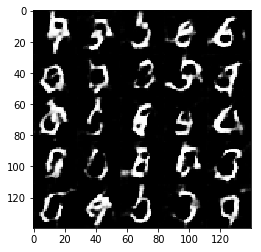

Epoch 1/2... Discriminator Loss: 1.2998... Generator Loss: 0.7496
Epoch 1/2... Discriminator Loss: 1.2599... Generator Loss: 0.7963
Epoch 1/2... Discriminator Loss: 1.3999... Generator Loss: 0.5394
Epoch 1/2... Discriminator Loss: 1.3907... Generator Loss: 0.7315
Epoch 1/2... Discriminator Loss: 1.2835... Generator Loss: 0.7560
Epoch 1/2... Discriminator Loss: 1.2218... Generator Loss: 0.8315
Epoch 1/2... Discriminator Loss: 1.2725... Generator Loss: 0.9137
Epoch 1/2... Discriminator Loss: 1.2904... Generator Loss: 0.7575
Epoch 1/2... Discriminator Loss: 1.2258... Generator Loss: 0.7408
Epoch 1/2... Discriminator Loss: 1.2774... Generator Loss: 0.7186


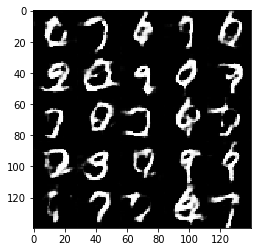

Epoch 1/2... Discriminator Loss: 1.3028... Generator Loss: 0.9284
Epoch 1/2... Discriminator Loss: 1.2711... Generator Loss: 0.8981
Epoch 1/2... Discriminator Loss: 1.2654... Generator Loss: 0.7865
Epoch 1/2... Discriminator Loss: 1.2768... Generator Loss: 0.6847
Epoch 1/2... Discriminator Loss: 1.2621... Generator Loss: 0.9891
Epoch 1/2... Discriminator Loss: 1.3670... Generator Loss: 1.1368
Epoch 1/2... Discriminator Loss: 1.2498... Generator Loss: 0.9305
Epoch 1/2... Discriminator Loss: 1.2759... Generator Loss: 0.8726
Epoch 1/2... Discriminator Loss: 1.2207... Generator Loss: 0.8589
Epoch 1/2... Discriminator Loss: 1.3045... Generator Loss: 0.9014


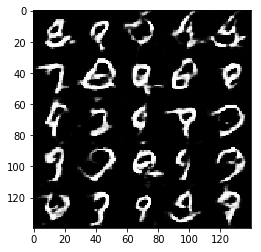

Epoch 1/2... Discriminator Loss: 1.1878... Generator Loss: 0.8247
Epoch 1/2... Discriminator Loss: 1.2424... Generator Loss: 0.8852
Epoch 1/2... Discriminator Loss: 1.3100... Generator Loss: 1.1939
Epoch 1/2... Discriminator Loss: 1.2457... Generator Loss: 0.9778
Epoch 1/2... Discriminator Loss: 1.2623... Generator Loss: 0.8137
Epoch 1/2... Discriminator Loss: 1.2290... Generator Loss: 0.8250
Epoch 2/2... Discriminator Loss: 1.2902... Generator Loss: 1.0858
Epoch 2/2... Discriminator Loss: 1.5411... Generator Loss: 0.6242
Epoch 2/2... Discriminator Loss: 1.5135... Generator Loss: 0.9530
Epoch 2/2... Discriminator Loss: 1.2370... Generator Loss: 0.8777


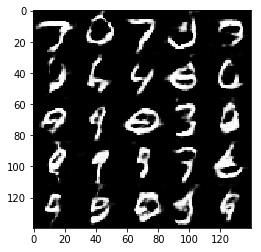

Epoch 2/2... Discriminator Loss: 1.2262... Generator Loss: 0.8372
Epoch 2/2... Discriminator Loss: 1.2280... Generator Loss: 0.8354
Epoch 2/2... Discriminator Loss: 1.2102... Generator Loss: 0.8441
Epoch 2/2... Discriminator Loss: 1.2682... Generator Loss: 0.8090
Epoch 2/2... Discriminator Loss: 1.2058... Generator Loss: 0.7782
Epoch 2/2... Discriminator Loss: 1.2350... Generator Loss: 1.0139
Epoch 2/2... Discriminator Loss: 1.2053... Generator Loss: 0.9371
Epoch 2/2... Discriminator Loss: 1.2670... Generator Loss: 0.8137
Epoch 2/2... Discriminator Loss: 1.1711... Generator Loss: 0.8541
Epoch 2/2... Discriminator Loss: 1.2492... Generator Loss: 0.9527


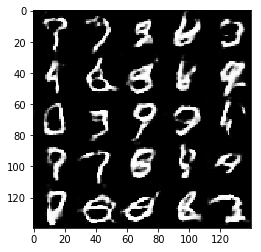

Epoch 2/2... Discriminator Loss: 1.1973... Generator Loss: 0.8918
Epoch 2/2... Discriminator Loss: 1.1959... Generator Loss: 0.9478
Epoch 2/2... Discriminator Loss: 2.8566... Generator Loss: 1.9350
Epoch 2/2... Discriminator Loss: 1.4307... Generator Loss: 0.5703
Epoch 2/2... Discriminator Loss: 1.3444... Generator Loss: 0.7962
Epoch 2/2... Discriminator Loss: 1.3247... Generator Loss: 0.7149
Epoch 2/2... Discriminator Loss: 1.2618... Generator Loss: 0.8270
Epoch 2/2... Discriminator Loss: 1.2351... Generator Loss: 0.8087
Epoch 2/2... Discriminator Loss: 1.2519... Generator Loss: 0.7913
Epoch 2/2... Discriminator Loss: 1.1907... Generator Loss: 0.8469


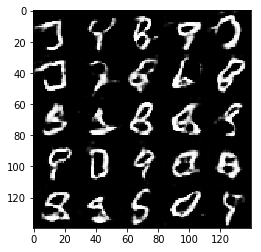

Epoch 2/2... Discriminator Loss: 1.2294... Generator Loss: 0.9356
Epoch 2/2... Discriminator Loss: 1.2860... Generator Loss: 0.7033
Epoch 2/2... Discriminator Loss: 1.2004... Generator Loss: 0.9573
Epoch 2/2... Discriminator Loss: 1.1951... Generator Loss: 0.9833
Epoch 2/2... Discriminator Loss: 1.2897... Generator Loss: 0.7386
Epoch 2/2... Discriminator Loss: 1.1947... Generator Loss: 0.7524
Epoch 2/2... Discriminator Loss: 1.2357... Generator Loss: 0.8924
Epoch 2/2... Discriminator Loss: 1.1831... Generator Loss: 0.9000
Epoch 2/2... Discriminator Loss: 1.1891... Generator Loss: 0.9250
Epoch 2/2... Discriminator Loss: 1.1771... Generator Loss: 0.9445


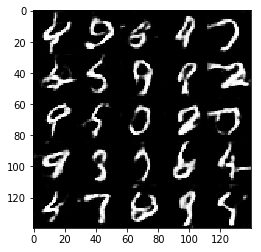

Epoch 2/2... Discriminator Loss: 1.3285... Generator Loss: 0.8059
Epoch 2/2... Discriminator Loss: 2.0607... Generator Loss: 1.1127
Epoch 2/2... Discriminator Loss: 1.3206... Generator Loss: 0.9603
Epoch 2/2... Discriminator Loss: 1.3463... Generator Loss: 0.5568
Epoch 2/2... Discriminator Loss: 1.2278... Generator Loss: 0.8620
Epoch 2/2... Discriminator Loss: 1.2168... Generator Loss: 0.9488
Epoch 2/2... Discriminator Loss: 1.2149... Generator Loss: 0.8758
Epoch 2/2... Discriminator Loss: 1.1842... Generator Loss: 0.8721
Epoch 2/2... Discriminator Loss: 1.1641... Generator Loss: 0.8081
Epoch 2/2... Discriminator Loss: 1.1480... Generator Loss: 0.7807


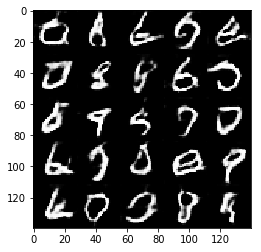

Epoch 2/2... Discriminator Loss: 1.2186... Generator Loss: 0.9343
Epoch 2/2... Discriminator Loss: 1.1669... Generator Loss: 0.8688
Epoch 2/2... Discriminator Loss: 1.2125... Generator Loss: 0.8753


In [31]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 0.7458... Generator Loss: 1.4547
Epoch 1/1... Discriminator Loss: 0.5058... Generator Loss: 1.7652
Epoch 1/1... Discriminator Loss: 1.5805... Generator Loss: 1.2052
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 1.0061
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.4370
Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 0.6763
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.6546


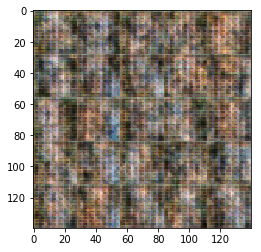

Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 2.2365... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.7419


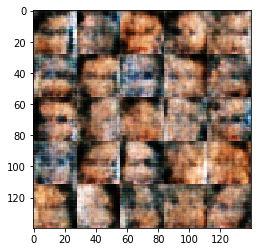

Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.6960


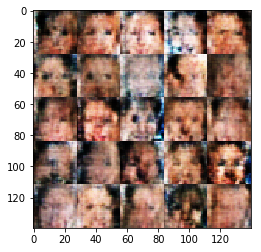

Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.5654... Generator Loss: 0.8361


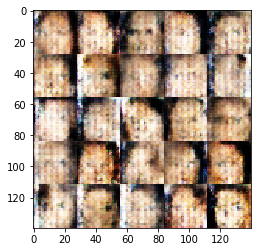

Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.6812


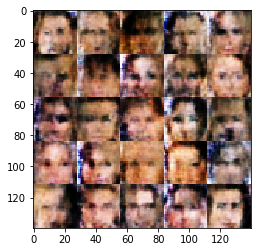

Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.7367


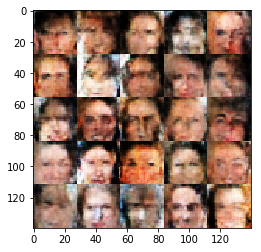

Epoch 1/1... Discriminator Loss: 2.5532... Generator Loss: 2.3088
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.5707
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.5723
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.8518
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7266


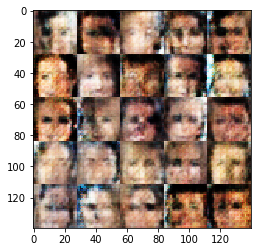

Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.6916


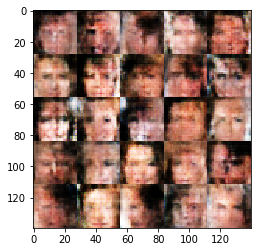

Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.6903


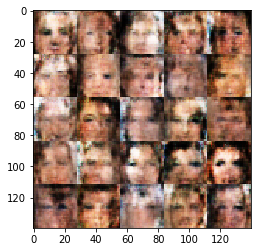

Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.6891
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.6678


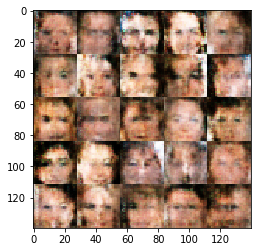

Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.6967


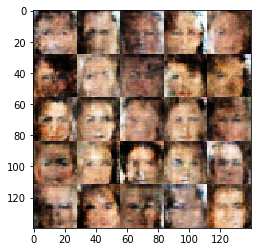

Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.7253


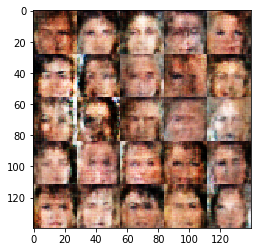

Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.6973


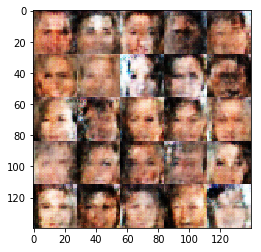

Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.6942


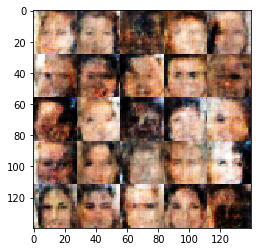

Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7233


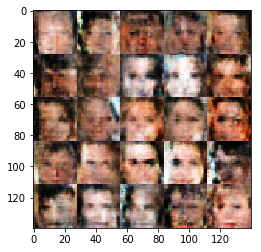

Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.6518
project finished


In [34]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.